# Imports

In [1]:
import torch
import torchvision
import matplotlib.pyplot as plt
import torch.nn.functional as F
import torch.nn as nn
import numpy as np
import matplotlib.pyplot as plt

from tqdm import tqdm
from torch.utils.data.dataloader import DataLoader
from torchvision import datasets
from torchvision.transforms import transforms
from transformers import ViTForImageClassification, ViTImageProcessorFast
from PIL import Image

from torchvision import models


torch.manual_seed(42)             # for CPU
torch.cuda.manual_seed(42)        # for current GPU
torch.cuda.manual_seed_all(42)  

mean = (.5,.5,.5)
sd = (.5,.5,.5)
# mean = (0.4914, 0.4822, 0.4465)
# std  = (0.2470, 0.2435, 0.2616)


device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
print(device)

2025-09-25 13:40:57.409372: E external/local_xla/xla/stream_executor/cuda/cuda_fft.cc:477] Unable to register cuFFT factory: Attempting to register factory for plugin cuFFT when one has already been registered
E0000 00:00:1758807657.588414      36 cuda_dnn.cc:8310] Unable to register cuDNN factory: Attempting to register factory for plugin cuDNN when one has already been registered
E0000 00:00:1758807657.638783      36 cuda_blas.cc:1418] Unable to register cuBLAS factory: Attempting to register factory for plugin cuBLAS when one has already been registered


cuda


In [2]:
train_transform = transforms.Compose([transforms.Resize(224),
                                transforms.RandomHorizontalFlip(),
                                transforms.RandomCrop(224, padding=4),
                                transforms.ToTensor(),
                                transforms.Normalize(mean,sd),])

test_transform = transforms.Compose([transforms.Resize(224),
                                transforms.ToTensor(),
                                transforms.Normalize(mean,sd),])

# Load train split

# train_data = datasets.CIFAR10(root='./data', download=True, train=True, transform=train_transform)
# test_data = datasets.CIFAR10(root='./data', download=True, train=False, transform=test_transform)

train_data = datasets.STL10(
    root="./data",
    split='train',
    download=True,
    transform=train_transform
)
# Load test split
test_data = datasets.STL10(
    root="./data",
    split='test',
    download=True,
    transform=test_transform
)

# print(len(train_data), len(test_data))

tr_loader = DataLoader(train_data,batch_size=128, shuffle=True)
te_loader = DataLoader(test_data, batch_size=128, shuffle=False,drop_last=True)

100%|██████████| 2.64G/2.64G [02:24<00:00, 18.3MB/s] 


# Test Function - ResNet

In [3]:
def test_resnet(model, loader):
    
    model.eval()
    correct_predictions = 0
    total = 0
    
    with torch.no_grad():
        for imgs, labels in loader:
            imgs, labels = imgs.to(device), labels.to(device)
    
            outputs = model(imgs)
            
            predictions = outputs.argmax(dim=1)
            correct_predictions += (predictions == labels).sum().item()
    
            total += labels.size(0)
            
        acc = (correct_predictions / total) * 100
    
    return acc  

# Test Function - ViT

In [4]:
def test_vit(model, loader):
    
    model.eval()
    # linear_probe.eval()
    
    correct_predictions = 0
    total = 0
    
    with torch.no_grad():
        for imgs, labels in loader:
            imgs, labels = imgs.to(device), labels.to(device)
    

            with torch.no_grad():
                outputs = model(imgs)

            logits = outputs.logits
                        
            predictions = logits.argmax(dim=1)
            correct_predictions += (predictions == labels).sum().item()
    
            total += labels.size(0)
            
        acc = (correct_predictions / total) * 100

    return acc        

# Train Function - ResNet

In [5]:
def train_resnet(model,train_loader, test_loader, n_epochs, optimizer, complete):

    train_acc = []
    val_acc = []
    # train_loss_list , val_loss_list = [], []
    best_acc = 0
    
    for epoch in range(n_epochs):
        #Per epoch
        model.train()
        
        correct_predictions = 0
        total = 0
        
        
        for imgs, labels in tqdm(train_loader, desc=f"Epoch {epoch}"):
            
            imgs, labels = imgs.to(device), labels.to(device)
            outputs = model(imgs)
            loss = criteria(outputs,labels)

            optimizer.zero_grad()
            loss.backward()           
            optimizer.step()
            
    
            predictions = outputs.argmax(dim=1)
            correct_predictions += (predictions == labels).sum().item()
    
            total += labels.size(0)
            
        t_acc = (correct_predictions / total) * 100
        train_acc.append(t_acc)
        
        v_acc = test_resnet(model, test_loader)
        val_acc.append(v_acc)

        if v_acc > best_acc:
            best_acc = v_acc
            '''Comment out to saved the trained model'''
            torch.save(model.state_dict(), f"R50_ft.pth")
            print(f"→ Saved Model")
        
        print(f"Train Acc: {t_acc:.2f}, Val Acc: {v_acc:.2f}")
        
     # --- Plot results ---
    plt.figure(figsize=(12,5))
    
    # # Loss curve
    # plt.subplot(1,2,1)
    # plt.plot(train_loss_list, label='Train Loss')
    # plt.plot(val_loss_list, label='Val Loss')
    # plt.xlabel('Epoch')
    # plt.ylabel('Loss')
    # plt.title('Loss Curve')
    # plt.legend()
    
    # Accuracy curve
    plt.subplot(1,2,2)
    plt.plot(train_acc, label='Train Acc')
    plt.plot(val_acc, label='Val Acc')
    plt.xlabel('Epoch')
    plt.ylabel('Accuracy (%)')
    plt.title('Accuracy Curve')
    plt.legend()
    
    plt.show()

# Train Function - ViT

In [6]:
def train_vit(model,train_loader, test_loader, n_epochs, optimizer, complete):

    
    train_acc = []
    val_acc = []

    best_acc = 0
    
    for epoch in range(n_epochs):
        
        model.train()
        
        correct_predictions = 0
        total = 0
        
        for imgs, labels in tqdm(train_loader, desc=f"Epoch {epoch}"):
            
            imgs, labels = imgs.to(device), labels.to(device)

            optimizer.zero_grad()
            
            outputs = model(imgs, labels=labels)
            logits = outputs.logits
            loss = outputs.loss
            
            
            loss.backward()           
            optimizer.step()
            
    
            predictions = logits.argmax(dim=1)
            correct_predictions += (predictions == labels).sum().item()
    
            total += labels.size(0)
            
        t_acc = (correct_predictions / total) * 100
        train_acc.append(t_acc)
        
        v_acc = test_vit(model,test_loader)
        val_acc.append(v_acc)

        if v_acc > best_acc:
            best_acc = v_acc
            '''Comment out to saved the trained model'''
            torch.save(model.state_dict(), f"vits16_ft.pth")
            print(f"→ Saved Model")
        
        print(f"Train Acc: {t_acc:.2f}, Val Acc: {v_acc:.2f}")


     # --- Plot results ---
    plt.figure(figsize=(12,5))
    
    # # Loss curve
    # plt.subplot(1,2,1)
    # plt.plot(train_loss_list, label='Train Loss')
    # plt.plot(val_loss_list, label='Val Loss')
    # plt.xlabel('Epoch')
    # plt.ylabel('Loss')
    # plt.title('Loss Curve')
    # plt.legend()
    
    # Accuracy curve
    plt.subplot(1,2,2)
    plt.plot(train_acc, label='Train Acc')
    plt.plot(val_acc, label='Val Acc')
    plt.xlabel('Epoch')
    plt.ylabel('Accuracy (%)')
    plt.title('Accuracy Curve')
    plt.legend()
    
    plt.show()

# Fine-Tuning || Turning off Gradients for All except Classifier Head


In [7]:
def fine_tune_fc(model):
    if model.__class__.__name__.lower().startswith("resnet"):
        print("This is a ResNet")
        for name,param in model.named_parameters():
            if 'fc' not in name:
                param.requires_grad = False
            else:
                param.requires_grad = True
    elif "vit" in model.__class__.__name__.lower():
        print("This is a ViT")
        for name,param in model.named_parameters():
            if 'classifier' not in name:
                param.requires_grad = False
            else:
                param.requires_grad = True
        

# ----Task 2----

* Exposing the differences in the inductive biases of CNNs and ViTs
* ResNet-50 vs ViT-S/16

1. Semantic Biases - texture | shape | colour etc
2. Architectural Biases - local | global 
3. Certain Invariances 

 ## Dataset - STL-10
 * 10 classes (similar to cifar-10) | Higher Res | Smaller Training Size

## Dataset(2) - Cifar-10  (IN USE)
* 10 classes 

# Semantic Biases

# Loading Resnet 50 Model | Fine-Tuning

This is a ResNet


Epoch 0: 100%|██████████| 40/40 [00:17<00:00,  2.26it/s]


→ Saved Model
Train Acc: 85.32, Val Acc: 95.74


Epoch 1: 100%|██████████| 40/40 [00:17<00:00,  2.27it/s]


→ Saved Model
Train Acc: 96.54, Val Acc: 96.85


Epoch 2: 100%|██████████| 40/40 [00:17<00:00,  2.24it/s]


→ Saved Model
Train Acc: 96.90, Val Acc: 97.01


Epoch 3: 100%|██████████| 40/40 [00:17<00:00,  2.25it/s]


→ Saved Model
Train Acc: 97.26, Val Acc: 97.05


Epoch 4: 100%|██████████| 40/40 [00:17<00:00,  2.27it/s]


→ Saved Model
Train Acc: 97.68, Val Acc: 97.19


Epoch 5: 100%|██████████| 40/40 [00:17<00:00,  2.24it/s]


→ Saved Model
Train Acc: 97.92, Val Acc: 97.28


Epoch 6: 100%|██████████| 40/40 [00:18<00:00,  2.21it/s]


Train Acc: 97.92, Val Acc: 97.25


Epoch 7: 100%|██████████| 40/40 [00:17<00:00,  2.25it/s]


Train Acc: 98.06, Val Acc: 97.26


Epoch 8: 100%|██████████| 40/40 [00:17<00:00,  2.26it/s]


→ Saved Model
Train Acc: 98.04, Val Acc: 97.34


Epoch 9: 100%|██████████| 40/40 [00:17<00:00,  2.26it/s]


Train Acc: 98.58, Val Acc: 97.30


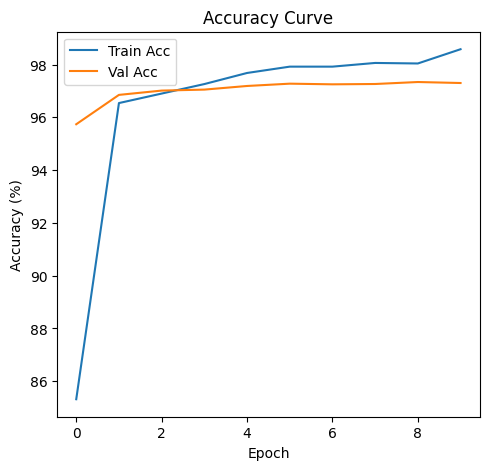

In [116]:
# R50_ptrained = models.resnet50(weights="IMAGENET1K_V2")

# in_feat = R50_ptrained.fc.in_features
# R50_ptrained.fc = nn.Linear(in_features=in_feat, out_features=10)

# R50_ptrained = R50_ptrained.to(device)



# n_epochs = 10
# criteria = nn.CrossEntropyLoss()
# optimizer = torch.optim.SGD(R50_ptrained.fc.parameters(),lr=0.01, momentum=0.9,weight_decay=5e-4)

# fine_tune_fc(R50_ptrained)

# train_resnet(R50_ptrained, tr_loader, te_loader,  n_epochs, optimizer, "fc")

# Loading pretrained ResNet

* Accuracy - 97.30%

In [79]:
R50_ptrained = models.resnet50(weights=None)
in_feat = R50_ptrained.fc.in_features
R50_ptrained.fc = nn.Linear(in_features=in_feat, out_features=10)

state_dict = torch.load('/kaggle/input/r50_stl/pytorch/default/1/R50_ft_STL10.pth')
R50_ptrained.load_state_dict(state_dict)

R50_ptrained = R50_ptrained.to(device)

test_resnet(R50_ptrained, te_loader)

97.49243951612904

# Loading ViT-16/S | Fine-Tuning

Some weights of ViTForImageClassification were not initialized from the model checkpoint at WinKawaks/vit-small-patch16-224 and are newly initialized because the shapes did not match:
- classifier.bias: found shape torch.Size([1000]) in the checkpoint and torch.Size([10]) in the model instantiated
- classifier.weight: found shape torch.Size([1000, 384]) in the checkpoint and torch.Size([10, 384]) in the model instantiated
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


This is a ViT


Epoch 0: 100%|██████████| 40/40 [00:19<00:00,  2.05it/s]


→ Saved Model
Train Acc: 15.68, Val Acc: 22.25


Epoch 1: 100%|██████████| 40/40 [00:19<00:00,  2.05it/s]


→ Saved Model
Train Acc: 32.52, Val Acc: 39.98


Epoch 2: 100%|██████████| 40/40 [00:19<00:00,  2.03it/s]


→ Saved Model
Train Acc: 53.08, Val Acc: 60.54


Epoch 3: 100%|██████████| 40/40 [00:19<00:00,  2.05it/s]


→ Saved Model
Train Acc: 71.42, Val Acc: 76.12


Epoch 4: 100%|██████████| 40/40 [00:19<00:00,  2.02it/s]


→ Saved Model
Train Acc: 83.18, Val Acc: 85.66


Epoch 5: 100%|██████████| 40/40 [00:19<00:00,  2.04it/s]


→ Saved Model
Train Acc: 90.04, Val Acc: 90.54


Epoch 6: 100%|██████████| 40/40 [00:19<00:00,  2.04it/s]


→ Saved Model
Train Acc: 93.54, Val Acc: 93.51


Epoch 7: 100%|██████████| 40/40 [00:19<00:00,  2.06it/s]


→ Saved Model
Train Acc: 95.52, Val Acc: 95.17


Epoch 8: 100%|██████████| 40/40 [00:19<00:00,  2.05it/s]


→ Saved Model
Train Acc: 96.42, Val Acc: 96.08


Epoch 9: 100%|██████████| 40/40 [00:19<00:00,  2.05it/s]


→ Saved Model
Train Acc: 96.96, Val Acc: 96.70


Epoch 10: 100%|██████████| 40/40 [00:19<00:00,  2.05it/s]


→ Saved Model
Train Acc: 97.58, Val Acc: 97.22


Epoch 11: 100%|██████████| 40/40 [00:19<00:00,  2.06it/s]


→ Saved Model
Train Acc: 97.96, Val Acc: 97.50


Epoch 12: 100%|██████████| 40/40 [00:19<00:00,  2.08it/s]


→ Saved Model
Train Acc: 98.22, Val Acc: 97.74


Epoch 13: 100%|██████████| 40/40 [00:19<00:00,  2.08it/s]


→ Saved Model
Train Acc: 98.28, Val Acc: 97.88


Epoch 14: 100%|██████████| 40/40 [00:18<00:00,  2.12it/s]


→ Saved Model
Train Acc: 98.60, Val Acc: 98.10


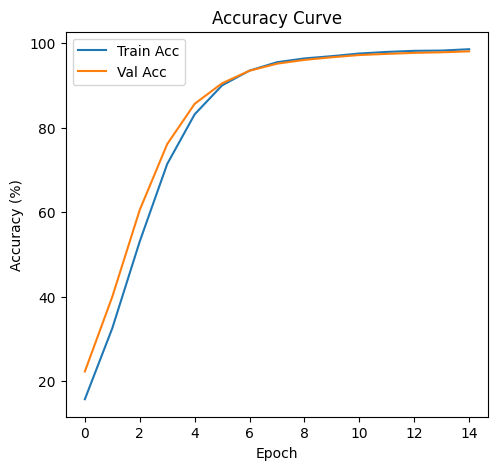

In [95]:
# ckpt = "WinKawaks/vit-small-patch16-224"  #pretrained on imagenet - taken from hugging face
# vit_s16_ptrained = ViTForImageClassification.from_pretrained(ckpt, num_labels=10, ignore_mismatched_sizes=True)


# vit_s16_ptrained = vit_s16_ptrained.to(device)
# #this ignores the weights for the classification head that we can fine-tune

# n_epochs = 15
# optimizer = torch.optim.Adam(vit_s16_ptrained.classifier.parameters(),lr=5e-5, weight_decay=0.05)
# # test_vit(vit_s16_ptrained,te_loader)



# #since the models performance drops indicating its backbone is forgetting crucial information
# # and is not extracting useful gradients to update weights, we only fine tune classifer

# fine_tune_fc(vit_s16_ptrained)
# train_vit(vit_s16_ptrained ,tr_loader, te_loader, n_epochs, optimizer, 'classifier')




# Loading the Pretrained ViT_S/16

In [80]:
ckpt = "WinKawaks/vit-small-patch16-224"
vit_s16_ptrained = ViTForImageClassification.from_pretrained(ckpt, num_labels=10, ignore_mismatched_sizes=True)

state_dict = torch.load('/kaggle/input/vit_stl/pytorch/default/1/vits16_ft_STL10.pth')
vit_s16_ptrained.load_state_dict(state_dict)

vit_s16_ptrained = vit_s16_ptrained.to(device)
test_vit(vit_s16_ptrained, te_loader)

Some weights of ViTForImageClassification were not initialized from the model checkpoint at WinKawaks/vit-small-patch16-224 and are newly initialized because the shapes did not match:
- classifier.bias: found shape torch.Size([1000]) in the checkpoint and torch.Size([10]) in the model instantiated
- classifier.weight: found shape torch.Size([1000, 384]) in the checkpoint and torch.Size([10, 384]) in the model instantiated
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


97.7570564516129

# Colour Bias Test

* We change the dataset to black & white only

Steps :
1. Create Grayscale Dataset
2. Run Diagnostics

# Converting Cifar-10 to Grayscale

In [18]:
# train_transform = transforms.Compose([transforms.Resize(224),
#                                 transforms.Grayscale(num_output_channels=3),
#                                 transforms.RandomHorizontalFlip(),
#                                 # transforms.RandomCrop(224, padding=4),
#                                 transforms.ToTensor(),
#                                 transforms.Normalize([mean,mean,mean],[sd,sd,sd]),])

test_transform = transforms.Compose([transforms.Resize(224),
                                transforms.Grayscale(num_output_channels=3),
                                transforms.ToTensor(),
                                transforms.Normalize(mean,sd),])

# Load train split

# train_data = datasets.CIFAR10(root='./data', download=False, train=True, transform=train_transform)
gs_test_data = datasets.STL10(root='./data', split='test', download=False, transform=test_transform)



print(len(train_data), len(test_data))

# tr_loader = DataLoader(train_data,batch_size=128, shuffle=True)
gs_test_loader = DataLoader(gs_test_data, batch_size=128, shuffle=False)
# , drop_last=True

5000 8000


In [19]:
test_resnet(R50_ptrained,gs_test_loader)


94.6875

In [20]:
test_vit(vit_s16_ptrained,gs_test_loader)

95.475

# CNNs have a greater color bias

* Accuracy for CNN's dropped to 94.68%
* Accuracy for ViT's dropped to 95.46%

# Cue Conflict


# Transformer Net - From Repo Link Attached:
[https://github.com/pytorch/examples/tree/main/fast_neural_style/neural_style](http://)

In [74]:
'''
Copied as it is from Fast_Neural_Style - Repo:
https://github.com/pytorch/examples/tree/main/fast_neural_style/neural_style

'''

class TransformerNet(torch.nn.Module):
    def __init__(self):
        super(TransformerNet, self).__init__()
        # Initial convolution layers
        self.conv1 = ConvLayer(3, 32, kernel_size=9, stride=1)
        self.in1 = torch.nn.InstanceNorm2d(32, affine=True)
        self.conv2 = ConvLayer(32, 64, kernel_size=3, stride=2)
        self.in2 = torch.nn.InstanceNorm2d(64, affine=True)
        self.conv3 = ConvLayer(64, 128, kernel_size=3, stride=2)
        self.in3 = torch.nn.InstanceNorm2d(128, affine=True)
        # Residual layers
        self.res1 = ResidualBlock(128)
        self.res2 = ResidualBlock(128)
        self.res3 = ResidualBlock(128)
        self.res4 = ResidualBlock(128)
        self.res5 = ResidualBlock(128)
        # Upsampling Layers
        self.deconv1 = UpsampleConvLayer(128, 64, kernel_size=3, stride=1, upsample=2)
        self.in4 = torch.nn.InstanceNorm2d(64, affine=True)
        self.deconv2 = UpsampleConvLayer(64, 32, kernel_size=3, stride=1, upsample=2)
        self.in5 = torch.nn.InstanceNorm2d(32, affine=True)
        self.deconv3 = ConvLayer(32, 3, kernel_size=9, stride=1)
        # Non-linearities
        self.relu = torch.nn.ReLU()

    def forward(self, X):
        y = self.relu(self.in1(self.conv1(X)))
        y = self.relu(self.in2(self.conv2(y)))
        y = self.relu(self.in3(self.conv3(y)))
        y = self.res1(y)
        y = self.res2(y)
        y = self.res3(y)
        y = self.res4(y)
        y = self.res5(y)
        y = self.relu(self.in4(self.deconv1(y)))
        y = self.relu(self.in5(self.deconv2(y)))
        y = self.deconv3(y)
        return y


class ConvLayer(torch.nn.Module):
    def __init__(self, in_channels, out_channels, kernel_size, stride):
        super(ConvLayer, self).__init__()
        reflection_padding = kernel_size // 2
        self.reflection_pad = torch.nn.ReflectionPad2d(reflection_padding)
        self.conv2d = torch.nn.Conv2d(in_channels, out_channels, kernel_size, stride)

    def forward(self, x):
        out = self.reflection_pad(x)
        out = self.conv2d(out)
        return out


class ResidualBlock(torch.nn.Module):
    """ResidualBlock
    introduced in: https://arxiv.org/abs/1512.03385
    recommended architecture: http://torch.ch/blog/2016/02/04/resnets.html
    """

    def __init__(self, channels):
        super(ResidualBlock, self).__init__()
        self.conv1 = ConvLayer(channels, channels, kernel_size=3, stride=1)
        self.in1 = torch.nn.InstanceNorm2d(channels, affine=True)
        self.conv2 = ConvLayer(channels, channels, kernel_size=3, stride=1)
        self.in2 = torch.nn.InstanceNorm2d(channels, affine=True)
        self.relu = torch.nn.ReLU()

    def forward(self, x):
        residual = x
        out = self.relu(self.in1(self.conv1(x)))
        out = self.in2(self.conv2(out))
        out = out + residual
        return out


class UpsampleConvLayer(torch.nn.Module):
    """UpsampleConvLayer
    Upsamples the input and then does a convolution. This method gives better results
    compared to ConvTranspose2d.
    ref: http://distill.pub/2016/deconv-checkerboard/
    """

    def __init__(self, in_channels, out_channels, kernel_size, stride, upsample=None):
        super(UpsampleConvLayer, self).__init__()
        self.upsample = upsample
        reflection_padding = kernel_size // 2
        self.reflection_pad = torch.nn.ReflectionPad2d(reflection_padding)
        self.conv2d = torch.nn.Conv2d(in_channels, out_channels, kernel_size, stride)

    def forward(self, x):
        x_in = x
        if self.upsample:
            x_in = torch.nn.functional.interpolate(x_in, mode='nearest', scale_factor=self.upsample)
        out = self.reflection_pad(x_in)
        out = self.conv2d(out)
        return out

# Helper Function - Create_stylized_stl10

In [75]:
from torchvision.utils import save_image
import os 

def create_stylized_stl10(
    style_model,
    output_dir="./cue_conflict_stl10",
    split="test",
    img_size=224,
    batch_size=128,
    num_workers=0
):
    """
    Create a stylized version of the STL-10 dataset using a style transfer model.
    
    Args:
        style_model: pretrained style transfer model (nn.Module).
        output_dir: where to save stylized dataset.
        split: 'train' or 'test' split of STL-10.
        img_size: resize images for model input.
        batch_size: batch size for processing.
        num_workers: dataloader workers.
    """
    style_model = style_model.to(device).eval()
    
    # Dataset & Loader
    transform = transforms.Compose([
        transforms.Resize((img_size, img_size)),
        transforms.ToTensor(),
        transforms.Normalize(mean,sd)
    ])
    
    dataset = datasets.STL10(root="./data", split=split, download=False, transform=transform)
    loader = torch.utils.data.DataLoader(dataset, batch_size=batch_size,
                                         shuffle=False, num_workers=num_workers)
    
    # Prepare output folders
    os.makedirs(output_dir, exist_ok=True)
    for c in range(10):  # STL-10 has 10 classes
        os.makedirs(os.path.join(output_dir, f"class_{c}"), exist_ok=True)
    
    print(f"Saving stylized STL-10 ({split} split) to {output_dir} ...")
    
    idx_counter = [0] * 10  # track image count per class
    
    with torch.no_grad():
        for imgs, labels in tqdm(loader):
            imgs, labels = imgs.to(device), labels.to(device)
            
            # Stylize
            stylized_imgs = style_model(imgs).clamp(0, 1)  # keep in [0,1]
            
            # Save per class
            for img_tensor, label in zip(stylized_imgs, labels):
                cls = int(label.item())
                idx_counter[cls] += 1
                save_path = os.path.join(output_dir, f"class_{cls}", f"{idx_counter[cls]:05d}.png")
                save_image(img_tensor, save_path)
    
    print("Stylized dataset created successfully!")


# Creating the Stylized Dataset
* Mosaic
* Candy
* Rain Princess
  > Pretrained models available on attached github link earlier

In [76]:

# Load pretrained style model (example: mosaic.pth)
style_model = TransformerNet()
state_dict = torch.load("/kaggle/input/pretrained_styling_models/pytorch/default/1/rain_princess.pth")

# Remove all InstanceNorm running stats
for k in list(state_dict.keys()):
    if "running_mean" in k or "running_var" in k:
        del state_dict[k]
style_model.load_state_dict(state_dict, strict=False)

# Generate stylized dataset
create_stylized_stl10(style_model, output_dir="./cue_conflict_stl10_rain_princess", split="test")


Saving stylized STL-10 (test split) to ./cue_conflict_stl10_rain_princess ...


100%|██████████| 63/63 [01:18<00:00,  1.24s/it]

Stylized dataset created successfully!


# Visualizing Images

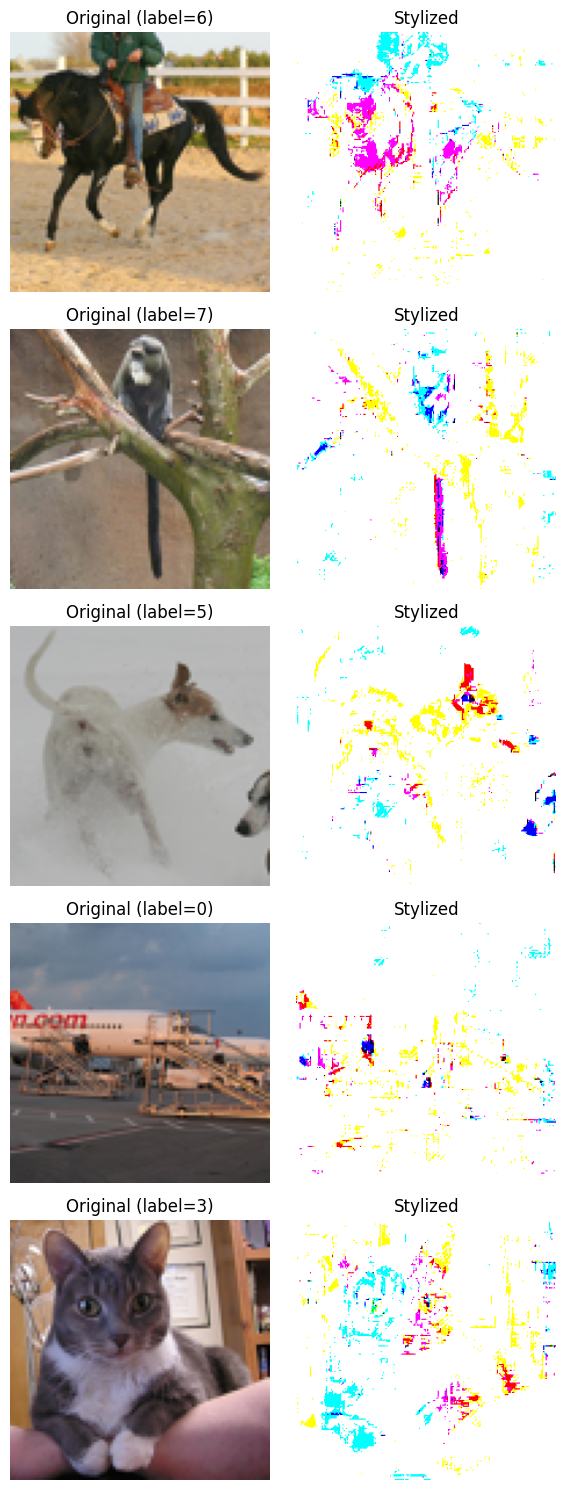

In [77]:

def visualize_stylized_samples(style_model, dataset, num_images=5, img_size=224):
    """
    Show original vs stylized images from the dataset.
    
    Args:
        style_model: pretrained style transfer model (nn.Module).
        dataset: torchvision dataset (e.g., STL10 with transform=ToTensor()).
        num_images: how many samples to show.
        img_size: size for model input.
    """
    style_model = style_model.to(device).eval()

    transform_resize = transforms.Compose([
        transforms.Resize((img_size, img_size)),
        # transforms.ToTensor(),
        transforms.Normalize(mean,sd)
    ])
    
    fig, axes = plt.subplots(num_images, 2, figsize=(6, num_images * 3))
    if num_images == 1:
        axes = [axes]

    for i in range(num_images):
        img, label = dataset[i]
        img_resized = transform_resize(img).unsqueeze(0).to(device)
        
        with torch.no_grad():
            stylized = style_model(img_resized).clamp(0, 1).cpu().squeeze(0)
        
        # Show original
        axes[i][0].imshow(img.permute(1, 2, 0))
        axes[i][0].set_title(f"Original (label={label})")
        axes[i][0].axis("off")

        # Show stylized
        axes[i][1].imshow(stylized.permute(1, 2, 0))
        axes[i][1].set_title("Stylized")
        axes[i][1].axis("off")

    plt.tight_layout()
    plt.show()


# Load dataset (raw images for visualization)
visualizeset = datasets.STL10(root="./data", split="test", download=False, transform=transforms.ToTensor())

# Visualize 5 samples
visualize_stylized_samples(style_model, visualizeset, num_images=5)


In [35]:
# Load stylized test dataset (ImageFolder assumes class subfolders)
test_transform = transforms.Compose([
    transforms.Resize((224, 224)),    # resize to match training
    transforms.ToTensor(),            # convert to tensor
    transforms.Normalize(mean, sd),   # normalize for pretrained model
])


stylized_dataset = datasets.ImageFolder(
    root="./cue_conflict_stl10_rain_princess",
    transform=test_transform
)

stylized_loader = DataLoader(stylized_dataset, batch_size=128, shuffle=False)

print(test_resnet(R50_ptrained, stylized_loader))
print(test_vit(vit_s16_ptrained, stylized_loader))

19.375
27.4125


12.8 / 97.3 = Shape bias \
17.8 / 97.5 = Shape bias 

> 13% & 18% respectively

candy \
14 / 97.3 = Shape bias \
15 / 97.5 = Shape bias 

rain princess \
19.375 / 97.3 = Shape bias \
27.4125 / 97.5 = Shape bias 



# Examples

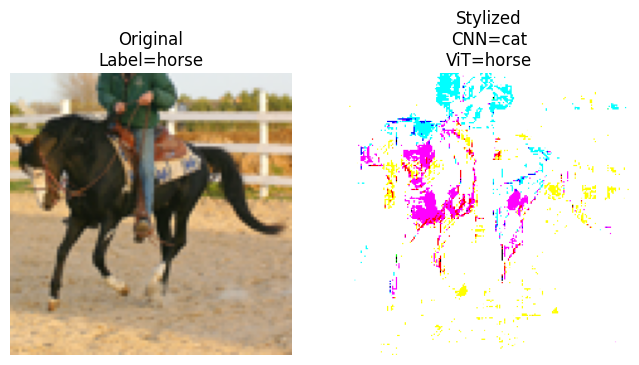

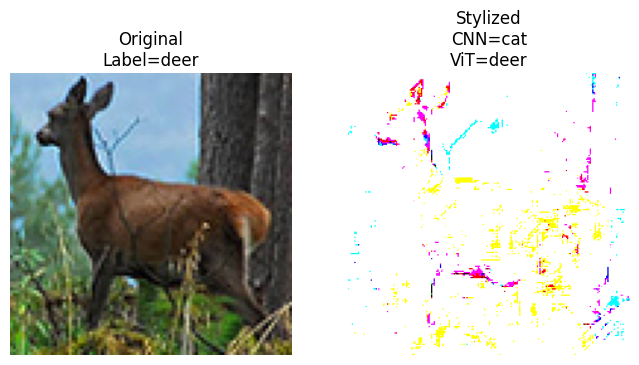

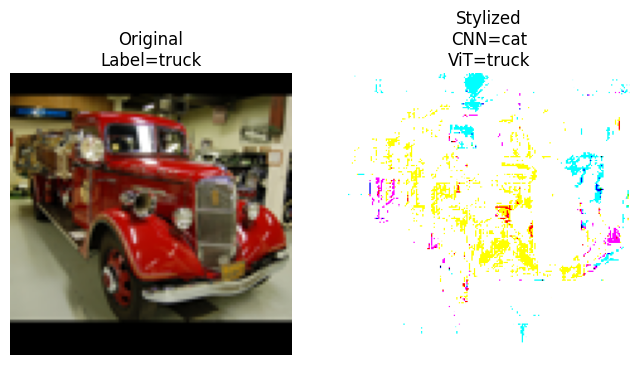

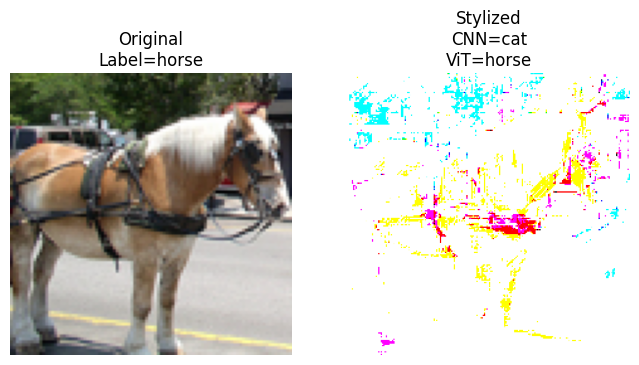

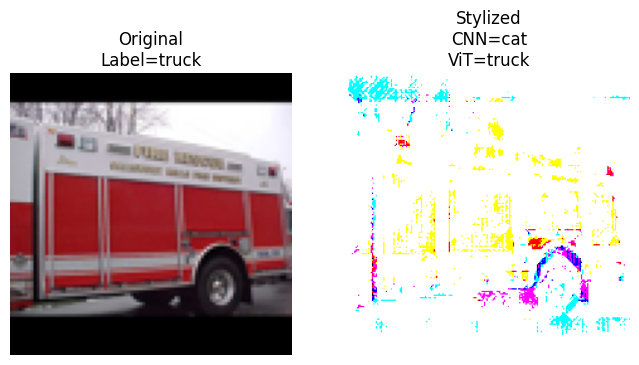

In [104]:
def visualize_stylized_predictions(style_model, dataset, vit_model, cnn_model, num_images=5, img_size=224):
    style_model.eval().to(device)
    vit_model.eval().to(device)
    cnn_model.eval().to(device)

    transform_resize = transforms.Compose([
        transforms.Resize((img_size, img_size))
    ])

    shown = 0
    for i in range(len(dataset)):
        img, label = dataset[i]
        img_resized = transform_resize(img).unsqueeze(0).to(device)

        # Stylize image
        with torch.no_grad():
            stylized = style_model(img_resized).clamp(0, 1)

        # Model predictions
        with torch.no_grad():
            vit_out = vit_model(stylized)
            if hasattr(vit_out, 'logits'):
                vit_out = vit_out.logits
            vit_pred = vit_out.argmax(dim=1).item()

            cnn_out = cnn_model(stylized)
            cnn_pred = cnn_out.argmax(dim=1).item()

        if vit_pred == label:
            # Show original and stylized images
            fig, axes = plt.subplots(1, 2, figsize=(8, 4))
            axes[0].imshow(img.permute(1, 2, 0))
            axes[0].set_title(f"Original\nLabel={dataset.classes[label]}")
            axes[0].axis("off")

            axes[1].imshow(stylized.squeeze(0).cpu().permute(1, 2, 0))
            axes[1].set_title(f"Stylized\nCNN={dataset.classes[cnn_pred]}\nViT={dataset.classes[vit_pred]}")
            axes[1].axis("off")

            plt.show()

            shown += 1
            if shown >= num_images:
                break
                
visualize_stylized_predictions(style_model, visualizeset, vit_s16_ptrained, R50_ptrained, num_images=5)


# Locality Bias

# Translation Tests

In [21]:
import numpy as np
import torch
from torchvision import transforms

class RandomTranslateWrap:
    def __init__(self, translate_frac=0.3):
        self.translate_frac = translate_frac

    def __call__(self, img):
        # convert PIL → np.array
        arr = np.array(img)
        h, w = arr.shape[:2]

        # random shifts
        max_dx = int(w * self.translate_frac)
        max_dy = int(h * self.translate_frac)
        dx = np.random.randint(-max_dx, max_dx + 1)
        dy = np.random.randint(-max_dy, max_dy + 1)

        # roll with wrap-around
        arr = np.roll(arr, shift=dy, axis=0)  # vertical
        arr = np.roll(arr, shift=dx, axis=1)  # horizontal

        # back to PIL
        return transforms.functional.to_pil_image(arr)

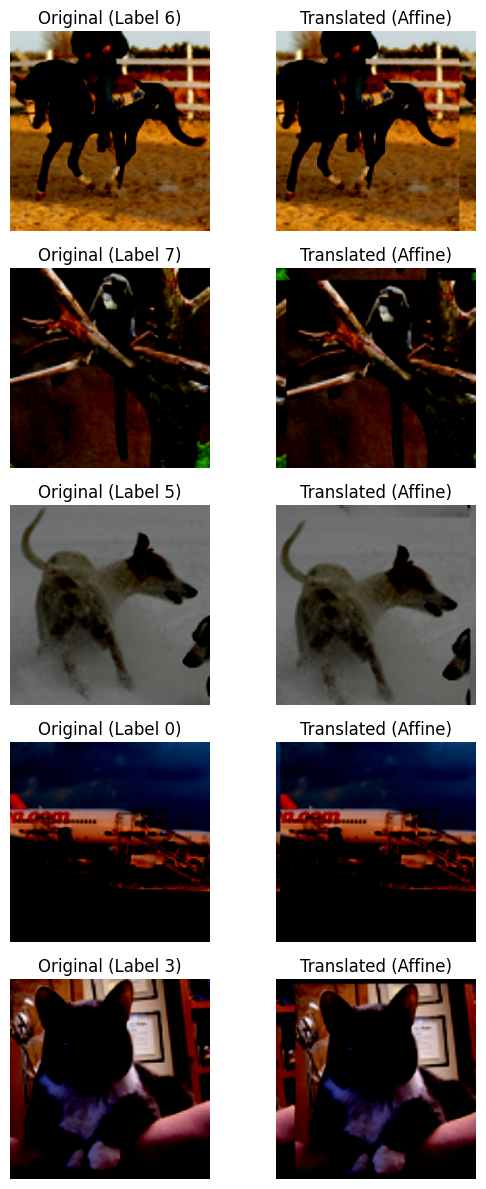

In [28]:

# mean = (.5,.5,.5)
# sd = (.5,.5,.5)

# translate_frac = 0.3

transform = transforms.Compose([
    RandomTranslateWrap(translate_frac=0.1),
    transforms.Resize(224),
    transforms.ToTensor(),
    transforms.Normalize(mean,sd),
])

original_transform = transforms.Compose([transforms.Resize(224), transforms.ToTensor(),transforms.Normalize(mean,sd),])


# Example for CIFAR-10 test set
test_set = torchvision.datasets.STL10(
    root="./data",
    split='test',
    download=False,
    transform=transform
)

translation_test_load = DataLoader(test_set,batch_size=128, shuffle=True)

test_orig = torchvision.datasets.STL10(root="./data", split='test', download=False, transform=original_transform)

# Show a few samples
num_samples = 5
fig, axes = plt.subplots(num_samples, 2, figsize=(6, 12))

for i in range(num_samples):
    # Original
    img_orig, label = test_orig[i]
    axes[i, 0].imshow(img_orig.permute(1, 2, 0))
    axes[i, 0].set_title(f"Original (Label {label})")
    axes[i, 0].axis('off')
    
    # Translated (RandomAffine)
    img_trans, _ = test_set[i]
    axes[i, 1].imshow(img_trans.permute(1, 2, 0))
    axes[i, 1].set_title("Translated (Affine)")
    axes[i, 1].axis('off')

plt.tight_layout()
plt.show()


In [29]:
print(test_resnet(R50_ptrained, translation_test_load))
print(test_vit(vit_s16_ptrained, translation_test_load))

97.32499999999999
97.4375


* For CNNs' there is no drop
* For ViT's there is a drop of .3%

# Patch Shuffling

In [30]:
class PatchShuffle:
    def __init__(self, patch_size=16, shuffle_ratio=1.0):
        self.patch_size = patch_size
        self.shuffle_ratio = shuffle_ratio  # fraction of patches to shuffle (0=none, 1=all)

    def __call__(self, img):
        # tensor = transforms.to_tensor(img)
        tensor = img
        C, H, W = tensor.shape
        ph, pw = self.patch_size, self.patch_size
        num_patches_h, num_patches_w = H // ph, W // pw
        num_patches = num_patches_h * num_patches_w

        # extract patches
        patches = tensor.unfold(1, ph, ph).unfold(2, pw, pw)  
        patches = patches.permute(1, 2, 0, 3, 4).contiguous().view(-1, C, ph, pw)

        # choose subset of patches to shuffle
        num_to_shuffle = int(self.shuffle_ratio * num_patches)
        shuffle_idx = torch.randperm(num_patches)[:num_to_shuffle]
        permuted_idx = shuffle_idx[torch.randperm(num_to_shuffle)]
        
        # apply shuffle only on selected subset
        new_patches = patches.clone()
        new_patches[shuffle_idx] = patches[permuted_idx]

        # reconstruct image
        patches = new_patches.view(num_patches_h, num_patches_w, C, ph, pw)
        patches = patches.permute(2, 0, 3, 1, 4).contiguous()
        return patches.view(C, H, W)


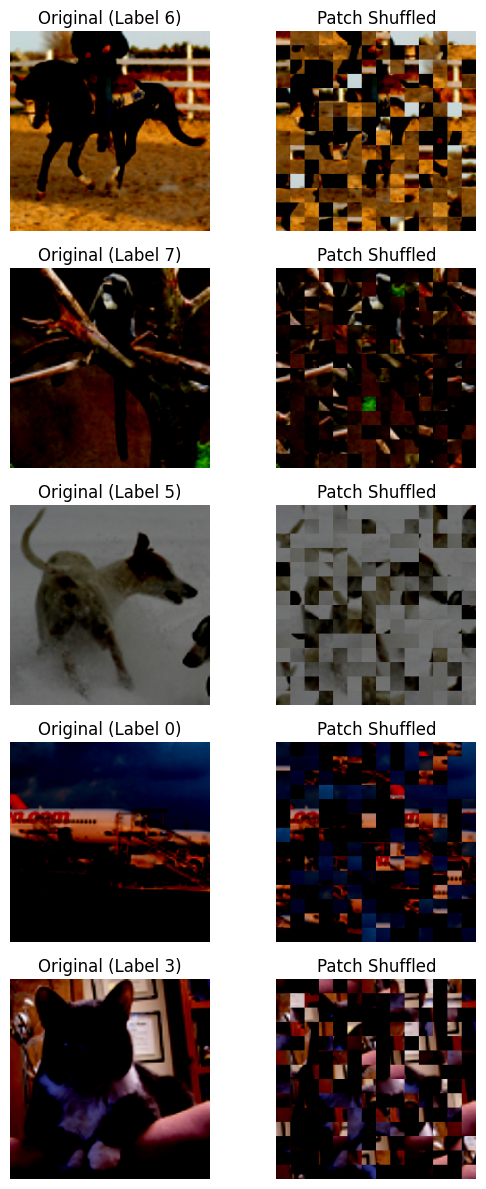

In [33]:

# Use the PatchShuffle class we made
transform = transforms.Compose([
    transforms.Resize(224),
    transforms.ToTensor(),
    transforms.Normalize(mean,sd),
    PatchShuffle(patch_size=16, shuffle_ratio=0.7),  # shuffle half the patches
])

# Load CIFAR-10 test set
patchshuffle_set = torchvision.datasets.STL10(root="./data", split='test', download=False, transform=transform)
patchshuffle_test_loader = DataLoader(patchshuffle_set, batch_size=128, shuffle=False)

# Original set (for side-by-side comparison)
orig = torchvision.datasets.STL10(root="./data", split='test', download=False,
                                          transform=transforms.Compose([transforms.Resize(224), transforms.ToTensor(),transforms.Normalize(mean,sd),]))

# Show a few examples
num_samples = 5
fig, axes = plt.subplots(num_samples, 2, figsize=(6, 12))

for i in range(num_samples):
    img_orig, label = orig[i]
    img_shuf, _ = patchshuffle_set[i]
    
    # Original
    axes[i, 0].imshow(img_orig.permute(1, 2, 0))
    axes[i, 0].set_title(f"Original (Label {label})")
    axes[i, 0].axis('off')
    
    # Patch-shuffled
    axes[i, 1].imshow(img_shuf.permute(1, 2, 0))
    axes[i, 1].set_title("Patch Shuffled")
    axes[i, 1].axis('off')

plt.tight_layout()
plt.show()


In [34]:
print(test_resnet(R50_ptrained, patchshuffle_test_loader))
print(test_vit(vit_s16_ptrained, patchshuffle_test_loader))

50.075
48.775


Thus this supports the hypothesis that CNNs are more robust to patch permutations
* For CNNs' there is a drop of 47.3% approximately
* For ViT's there is a drop of 49% approximately

# Patch Occlusion

In [35]:

class PatchOcclusion:
    def __init__(self, patch_size=16, occlusion_ratio=0.3):
        """
        patch_size: size of square patches (px)
        occlusion_ratio: fraction of patches to mask out
        """
        self.patch_size = patch_size
        self.occlusion_ratio = occlusion_ratio

    def __call__(self, img):
        # Convert PIL to tensor (C,H,W)
        tensor = img
        C, H, W = tensor.shape
        ph, pw = self.patch_size, self.patch_size

        assert H % ph == 0 and W % pw == 0, "Image must be divisible by patch size"

        # Compute number of patches
        num_patches_h, num_patches_w = H // ph, W // pw
        num_patches = num_patches_h * num_patches_w

        # Flatten patches
        patches = tensor.unfold(1, ph, ph).unfold(2, pw, pw)  
        patches = patches.permute(1, 2, 0, 3, 4).contiguous().view(-1, C, ph, pw)

        # Pick random subset to occlude
        num_to_occlude = int(self.occlusion_ratio * num_patches)
        occlude_idx = torch.randperm(num_patches)[:num_to_occlude]

        # Zero-out chosen patches
        patches[occlude_idx] = 0.0

        # Reconstruct image
        patches = patches.view(num_patches_h, num_patches_w, C, ph, pw)
        patches = patches.permute(2, 0, 3, 1, 4).contiguous()
        tensor_occluded = patches.view(C, H, W)

        return tensor_occluded


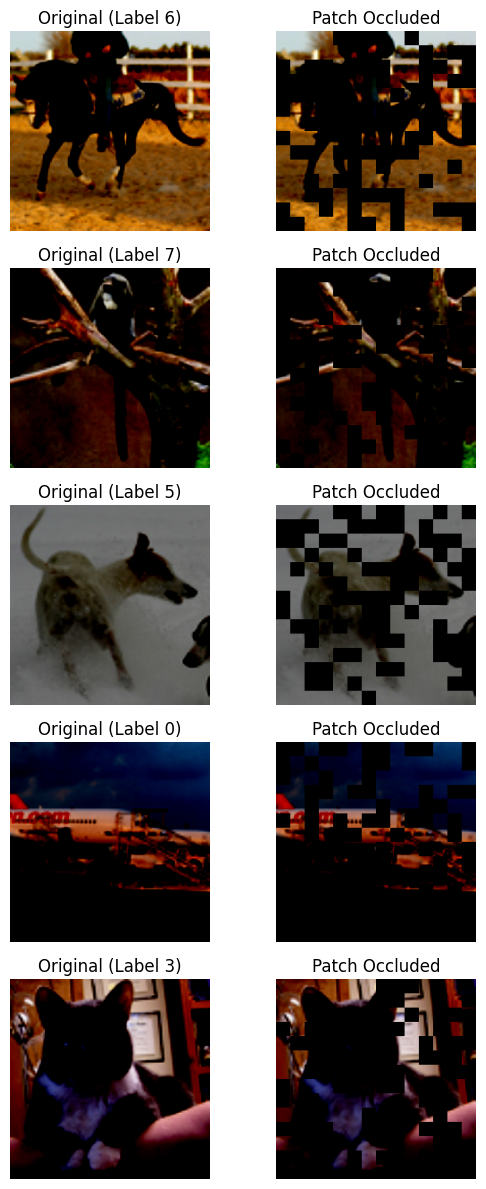

In [43]:
# # Patch Occlusion transform
transform = transforms.Compose([
    transforms.Resize(224),
    transforms.ToTensor(),
    transforms.Normalize(mean,sd),
    PatchOcclusion(patch_size=16, occlusion_ratio=0.4),  # mask out 40% of patches
])

# Load datasets
occlusion_set = torchvision.datasets.STL10(root="./data", split='test', download=False, transform=transform)
occlusion_test_loader = DataLoader(occlusion_set, batch_size=128, shuffle=False)

orig = torchvision.datasets.STL10(root="./data", split='test', download=False,
                                          transform=transforms.Compose([transforms.Resize(224), transforms.ToTensor(),transforms.Normalize(mean,sd),]))

# Show examples
num_samples = 5
fig, axes = plt.subplots(num_samples, 2, figsize=(6, 12))

for i in range(num_samples):
    img_orig, label = orig[i]
    img_occ, _ = occlusion_set[i]
    
    # Original
    axes[i, 0].imshow(img_orig.permute(1, 2, 0))
    axes[i, 0].set_title(f"Original (Label {label})")
    axes[i, 0].axis('off')
    
    # Occluded
    axes[i, 1].imshow(img_occ.permute(1, 2, 0))
    axes[i, 1].set_title("Patch Occluded")
    axes[i, 1].axis('off')

plt.tight_layout()
plt.show()


In [44]:
print(test_resnet(R50_ptrained, occlusion_test_loader))
print(test_vit(vit_s16_ptrained, occlusion_test_loader))

91.75
95.0625


Patch Occlusion is expected to hurt CNNs more than ViTs as they depend on local information more than
ViT's and blacking them out hurts the feature vectors created by the model layers as it is inherently focused more on the local features. Hence ViTs perform better:

* CNNs accuracy is 91.75% - drop of 5.8% approximately
* ViTs accuracy is 95.06% - drop of 2.7% approximately
  

# Feature Visualizations

# ResNet Visualization

Layer: layer3, batch: 0, shape: torch.Size([128, 1024, 14, 14])
Layer: layer3, batch: 1, shape: torch.Size([128, 1024, 14, 14])
Layer: layer3, batch: 2, shape: torch.Size([128, 1024, 14, 14])
Layer: layer3, batch: 3, shape: torch.Size([128, 1024, 14, 14])
Layer: layer3, batch: 4, shape: torch.Size([128, 1024, 14, 14])
Layer: layer3, batch: 5, shape: torch.Size([128, 1024, 14, 14])
Layer: layer3, batch: 6, shape: torch.Size([128, 1024, 14, 14])
Layer: layer3, batch: 7, shape: torch.Size([128, 1024, 14, 14])
Layer: layer3, batch: 8, shape: torch.Size([128, 1024, 14, 14])
Layer: layer3, batch: 9, shape: torch.Size([128, 1024, 14, 14])
Layer: layer3, batch: 10, shape: torch.Size([128, 1024, 14, 14])
Layer: layer3, batch: 11, shape: torch.Size([128, 1024, 14, 14])
Layer: layer3, batch: 12, shape: torch.Size([128, 1024, 14, 14])
Layer: layer3, batch: 13, shape: torch.Size([128, 1024, 14, 14])
Layer: layer3, batch: 14, shape: torch.Size([128, 1024, 14, 14])
Layer: layer3, batch: 15, shape: to

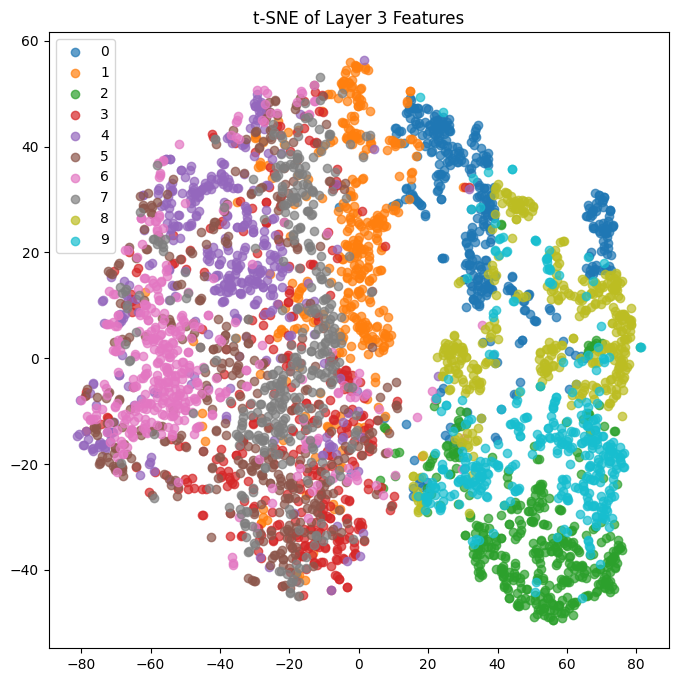

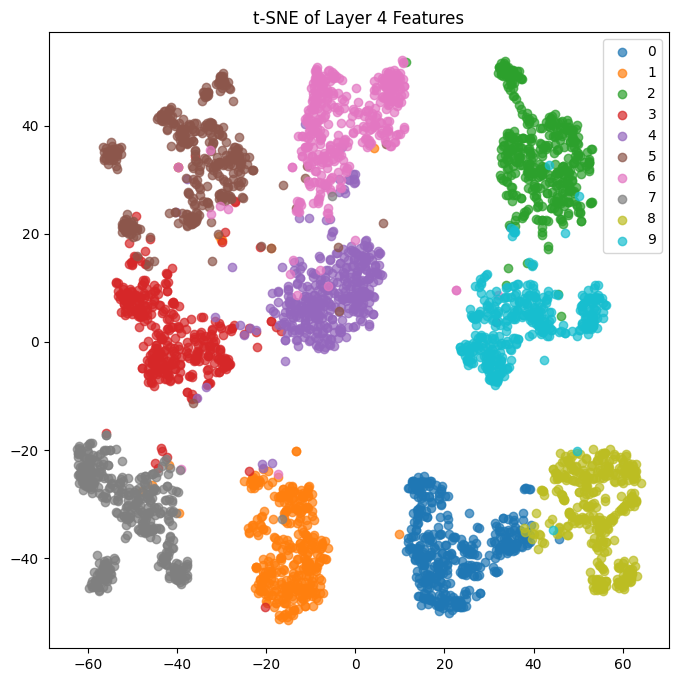

In [10]:
from collections import defaultdict, deque
layers_to_hook = {
    # "early" :    "layer1",   # last Bottleneck of layer1
    # "middle":    "layer2",  # last Bottleneck of layer2
    "late"  :    "layer3",     # last Bottleneck of layer4
    "last"  :    "avgpool"
}


features = defaultdict(lambda: deque(maxlen=30))  # store max 3 batches per layer

def save_features(name):
    
    def hook(module,args,output):
        features[name].append(output.detach().cpu())
    return hook

def registerhook(model):
    for name,module in model.named_modules():
        if name in layers_to_hook.values():
            module.register_forward_hook(save_features(name))




registerhook(R50_ptrained)

test_resnet(R50_ptrained, te_loader)

# print(f"Test Acc: {test_accuracy:.2f}")
for name in features:
    for i, batch_features in enumerate(features[name]):
        print(f"Layer: {name}, batch: {i}, shape: {batch_features.shape}")        


concatenated_features = {}

for layer_name, batch_deque in features.items():
    #batch_deque is a deque of tensors 
    concatenated_features[layer_name] = torch.cat(list(batch_deque), dim=0)
    
    print(f"Layer: {layer_name}, concatenated shape: {concatenated_features[layer_name].shape}")

# concatenating together
batch_size = concatenated_features["layer3"].size(0)

torch.save({
    # "layer1": concatenated_features["layer1"],
    # "layer2": concatenated_features["layer2"],
    "layer3": concatenated_features["layer3"],
    "avgpool": concatenated_features["avgpool"]
}, "all_features.pt")

# features_flat_1 = concatenated_features["layer1"].view(batch_size, -1).cpu().detach().numpy()
# features_flat_2 = concatenated_features["layer2"].view(batch_size, -1).cpu().detach().numpy()
features_flat_3 = concatenated_features["layer3"].view(batch_size, -1).cpu().detach().numpy()
features_flat_4 = concatenated_features["avgpool"].view(batch_size, -1).cpu().detach().numpy()

from sklearn.manifold import TSNE
from sklearn.decomposition import PCA
import os
# import torch

os.environ["OMP_NUM_THREADS"] = "1"  # limit OpenMP threads
os.environ["OPENBLAS_NUM_THREADS"] = "1"
torch.set_num_threads(1)

# def get_tsne(features):
    
#     tsne = TSNE(n_components=2, perplexity=30, learning_rate=200, random_state=42)
    
#     embedded_2d = tsne.fit_transform(features)
    
#     print(embedded_2d.shape)
    
#     return embedded_2d


def get_tsne(features, n_pca=50):
    # Step 1: PCA
    pca = PCA(n_components=n_pca, random_state=42)
    features_pca = pca.fit_transform(features)
    # print(f"PCA explained variance: {pca.explained_variance_ratio_.sum():.3f}")
    
    # Step 2: t-SNE on PCA features
    tsne = TSNE(n_components=2, perplexity=30, learning_rate=200, random_state=42)
    embedded_2d = tsne.fit_transform(features_pca)
    
    return embedded_2d

'''
Rule of thumb:

Usually between 5 and 50.
Should be less than the number of samples. 
A common heuristic: perplexity < N / 3 where N is the number of samples.
'''

# embedded_f1 = get_tsne(features_flat_1)
# embedded_f2 = get_tsne(features_flat_2)
embedded_f3 = get_tsne(features_flat_3)
embedded_f4 = get_tsne(features_flat_4)

import matplotlib.pyplot as plt

# Comment them out once to get the last labels
last_labels = deque(maxlen=30)

for _, labels in te_loader:
    last_labels.append(labels)

labels = torch.cat(list(last_labels), dim=0)

print(labels.shape)

labels = labels.cpu().numpy()

def plot_tsne(embedded, labels, title="t-SNE", n_classes=10):
    plt.figure(figsize=(8, 8))
    for i in range(n_classes):
        idxs = labels == i
        plt.scatter(embedded[idxs, 0], embedded[idxs, 1], label=str(i), alpha=0.7)
    plt.legend()
    plt.title(title)
    plt.show()

# plot_tsne(embedded_f1, labels, title="t-SNE of Layer 1 Features")
# plot_tsne(embedded_f2, labels, title="t-SNE of Layer 2 Features")
plot_tsne(embedded_f3, labels, title="t-SNE of Layer 3 Features")
plot_tsne(embedded_f4, labels, title="t-SNE of Layer 4 Features")


# ViT Visualization

Layer: vit.layernorm, batch: 0, shape: torch.Size([128, 197, 384])
Layer: vit.layernorm, batch: 1, shape: torch.Size([128, 197, 384])
Layer: vit.layernorm, batch: 2, shape: torch.Size([128, 197, 384])
Layer: vit.layernorm, batch: 3, shape: torch.Size([128, 197, 384])
Layer: vit.layernorm, batch: 4, shape: torch.Size([128, 197, 384])
Layer: vit.layernorm, batch: 5, shape: torch.Size([128, 197, 384])
Layer: vit.layernorm, batch: 6, shape: torch.Size([128, 197, 384])
Layer: vit.layernorm, batch: 7, shape: torch.Size([128, 197, 384])
Layer: vit.layernorm, batch: 8, shape: torch.Size([128, 197, 384])
Layer: vit.layernorm, batch: 9, shape: torch.Size([128, 197, 384])
Layer: vit.layernorm, batch: 10, shape: torch.Size([128, 197, 384])
Layer: vit.layernorm, batch: 11, shape: torch.Size([128, 197, 384])
Layer: vit.layernorm, batch: 12, shape: torch.Size([128, 197, 384])
Layer: vit.layernorm, batch: 13, shape: torch.Size([128, 197, 384])
Layer: vit.layernorm, batch: 14, shape: torch.Size([128, 1

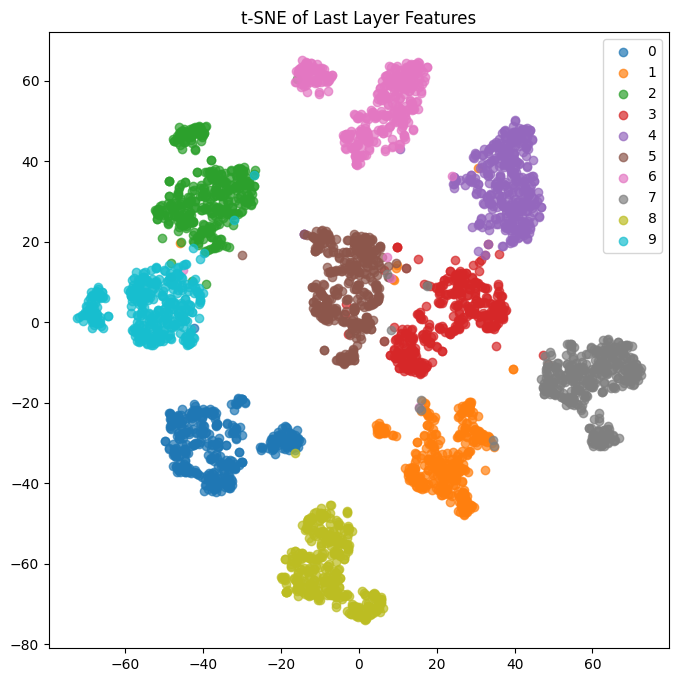

In [13]:
from collections import defaultdict, deque
layers_to_hook = {
    # "early" :    "layer1",   # last Bottleneck of layer1
    # "middle":    "layer2",  # last Bottleneck of layer2
    # "late"  :    "layer3",     # last Bottleneck of layer4
    "last"  :    "vit.layernorm"
}


features = defaultdict(lambda: deque(maxlen=30))  # store max 3 batches per layer

def save_features(name):
    
    def hook(module,args,output):
        features[name].append(output.detach().cpu())
    return hook

def registerhook(model):
    for name,module in model.named_modules():
        if name in layers_to_hook.values():
            module.register_forward_hook(save_features(name))




registerhook(vit_s16_ptrained)

test_vit(vit_s16_ptrained, te_loader)

# print(f"Test Acc: {test_accuracy:.2f}")
for name in features:
    for i, batch_features in enumerate(features[name]):
        print(f"Layer: {name}, batch: {i}, shape: {batch_features.shape}")        


concatenated_features = {}

for layer_name, batch_deque in features.items():
    #batch_deque is a deque of tensors 
    concatenated_features[layer_name] = torch.cat(list(batch_deque), dim=0)
    
    print(f"Layer: {layer_name}, concatenated shape: {concatenated_features[layer_name].shape}")

# concatenating together
batch_size = concatenated_features["vit.layernorm"].size(0)

torch.save({
    # "layer1": concatenated_features["layer1"],
    # "layer2": concatenated_features["layer2"],
    # "layer3": concatenated_features["layer3"],
    "vit.layernorm": concatenated_features["vit.layernorm"]
}, "all_features.pt")

# features_flat_1 = concatenated_features["layer1"].view(batch_size, -1).cpu().detach().numpy()
# features_flat_2 = concatenated_features["layer2"].view(batch_size, -1).cpu().detach().numpy()
# features_flat_3 = concatenated_features["layer3"].view(batch_size, -1).cpu().detach().numpy()
features_flat_4 = concatenated_features["vit.layernorm"].view(batch_size, -1).cpu().detach().numpy()

from sklearn.manifold import TSNE
from sklearn.decomposition import PCA
import os
# import torch

os.environ["OMP_NUM_THREADS"] = "1"  # limit OpenMP threads
os.environ["OPENBLAS_NUM_THREADS"] = "1"
torch.set_num_threads(1)

# def get_tsne(features):
    
#     tsne = TSNE(n_components=2, perplexity=30, learning_rate=200, random_state=42)
    
#     embedded_2d = tsne.fit_transform(features)
    
#     print(embedded_2d.shape)
    
#     return embedded_2d


def get_tsne(features, n_pca=50):
    # Step 1: PCA
    pca = PCA(n_components=n_pca, random_state=42)
    features_pca = pca.fit_transform(features)
    # print(f"PCA explained variance: {pca.explained_variance_ratio_.sum():.3f}")
    
    # Step 2: t-SNE on PCA features
    tsne = TSNE(n_components=2, perplexity=30, learning_rate=200, random_state=42)
    embedded_2d = tsne.fit_transform(features_pca)
    
    return embedded_2d

'''
Rule of thumb:

Usually between 5 and 50.
Should be less than the number of samples. 
A common heuristic: perplexity < N / 3 where N is the number of samples.
'''

# embedded_f1 = get_tsne(features_flat_1)
# embedded_f2 = get_tsne(features_flat_2)
# embedded_f3 = get_tsne(features_flat_3)
embedded_f4 = get_tsne(features_flat_4)

import matplotlib.pyplot as plt

# Comment them out once to get the last labels
last_labels = deque(maxlen=30)

for _, labels in te_loader:
    last_labels.append(labels)

labels = torch.cat(list(last_labels), dim=0)

print(labels.shape)

labels = labels.cpu().numpy()

def plot_tsne(embedded, labels, title="t-SNE", n_classes=10):
    plt.figure(figsize=(8, 8))
    for i in range(n_classes):
        idxs = labels == i
        plt.scatter(embedded[idxs, 0], embedded[idxs, 1], label=str(i), alpha=0.7)
    plt.legend()
    plt.title(title)
    plt.show()

# plot_tsne(embedded_f1, labels, title="t-SNE of Layer 1 Features")
# plot_tsne(embedded_f2, labels, title="t-SNE of Layer 2 Features")
# plot_tsne(embedded_f3, labels, title="t-SNE of Layer 3 Features")
plot_tsne(embedded_f4, labels, title="t-SNE of Last Layer Features")


# Getting the Stylized dataset for Visualization

* Change the address to get a different type of stylized dataset

In [78]:

test_transform = transforms.Compose([
    transforms.Resize((224, 224)),    # resize to match training
    transforms.ToTensor(),            # convert to tensor
    transforms.Normalize(mean, sd),   # normalize for pretrained model
])


stylized_dataset = datasets.ImageFolder(
    root="./cue_conflict_stl10_rain_princess",
    transform=test_transform
)

stylized_loader = DataLoader(stylized_dataset, batch_size=128, shuffle=False, drop_last=True)

# ResNet50 Stylized STL10 Visualization

Layer: avgpool, batch: 0, shape: torch.Size([128, 2048, 1, 1])
Layer: avgpool, batch: 1, shape: torch.Size([128, 2048, 1, 1])
Layer: avgpool, batch: 2, shape: torch.Size([128, 2048, 1, 1])
Layer: avgpool, batch: 3, shape: torch.Size([128, 2048, 1, 1])
Layer: avgpool, batch: 4, shape: torch.Size([128, 2048, 1, 1])
Layer: avgpool, batch: 5, shape: torch.Size([128, 2048, 1, 1])
Layer: avgpool, batch: 6, shape: torch.Size([128, 2048, 1, 1])
Layer: avgpool, batch: 7, shape: torch.Size([128, 2048, 1, 1])
Layer: avgpool, batch: 8, shape: torch.Size([128, 2048, 1, 1])
Layer: avgpool, batch: 9, shape: torch.Size([128, 2048, 1, 1])
Layer: avgpool, batch: 10, shape: torch.Size([128, 2048, 1, 1])
Layer: avgpool, batch: 11, shape: torch.Size([128, 2048, 1, 1])
Layer: avgpool, batch: 12, shape: torch.Size([128, 2048, 1, 1])
Layer: avgpool, batch: 13, shape: torch.Size([128, 2048, 1, 1])
Layer: avgpool, batch: 14, shape: torch.Size([128, 2048, 1, 1])
Layer: avgpool, batch: 15, shape: torch.Size([128,

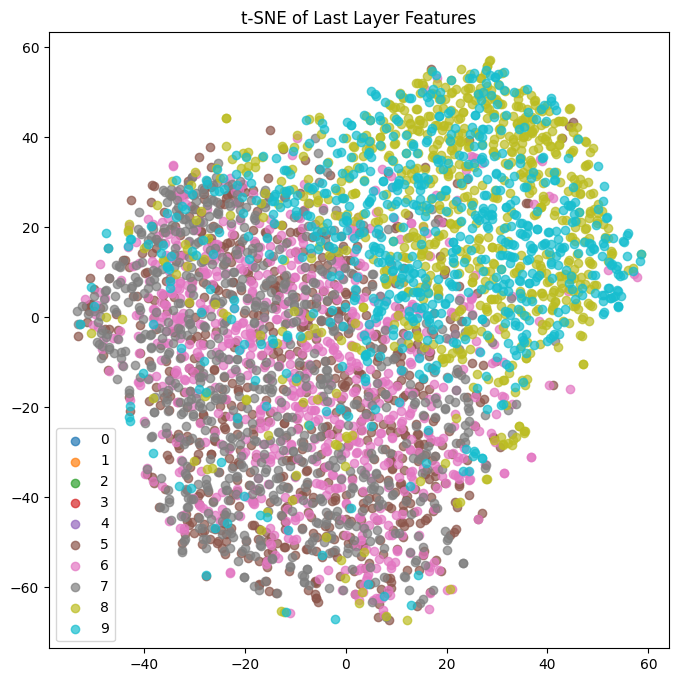

In [81]:
from collections import defaultdict, deque
layers_to_hook = {
    # "early" :    "layer1",   # last Bottleneck of layer1
    # "middle":    "layer2",  # last Bottleneck of layer2
    # "late"  :    "layer3",     # last Bottleneck of layer4
    "last"  :    "avgpool"
}


features = defaultdict(lambda: deque(maxlen=30))  # store max 3 batches per layer

def save_features(name):
    
    def hook(module,args,output):
        features[name].append(output.detach().cpu())
    return hook

def registerhook(model):
    for name,module in model.named_modules():
        if name in layers_to_hook.values():
            module.register_forward_hook(save_features(name))




registerhook(R50_ptrained)

test_resnet(R50_ptrained, stylized_loader)

# print(f"Test Acc: {test_accuracy:.2f}")
for name in features:
    for i, batch_features in enumerate(features[name]):
        print(f"Layer: {name}, batch: {i}, shape: {batch_features.shape}")        


concatenated_features = {}

for layer_name, batch_deque in features.items():
    #batch_deque is a deque of tensors 
    concatenated_features[layer_name] = torch.cat(list(batch_deque), dim=0)
    
    print(f"Layer: {layer_name}, concatenated shape: {concatenated_features[layer_name].shape}")

# concatenating together
batch_size = concatenated_features["avgpool"].size(0)

torch.save({
    # "layer1": concatenated_features["layer1"],
    # "layer2": concatenated_features["layer2"],
    # "layer3": concatenated_features["layer3"],
    "avgpool": concatenated_features["avgpool"]
}, "all_features.pt")

# features_flat_1 = concatenated_features["layer1"].view(batch_size, -1).cpu().detach().numpy()
# features_flat_2 = concatenated_features["layer2"].view(batch_size, -1).cpu().detach().numpy()
# features_flat_3 = concatenated_features["layer3"].view(batch_size, -1).cpu().detach().numpy()
features_flat_4 = concatenated_features["avgpool"].view(batch_size, -1).cpu().detach().numpy()

from sklearn.manifold import TSNE
from sklearn.decomposition import PCA
import os
# import torch

os.environ["OMP_NUM_THREADS"] = "1"  # limit OpenMP threads
os.environ["OPENBLAS_NUM_THREADS"] = "1"
torch.set_num_threads(1)

# def get_tsne(features):
    
#     tsne = TSNE(n_components=2, perplexity=30, learning_rate=200, random_state=42)
    
#     embedded_2d = tsne.fit_transform(features)
    
#     print(embedded_2d.shape)
    
#     return embedded_2d


def get_tsne(features, n_pca=50):
    # Step 1: PCA
    pca = PCA(n_components=n_pca, random_state=42)
    features_pca = pca.fit_transform(features)
    # print(f"PCA explained variance: {pca.explained_variance_ratio_.sum():.3f}")
    
    # Step 2: t-SNE on PCA features
    tsne = TSNE(n_components=2, perplexity=30, learning_rate=200, random_state=42)
    embedded_2d = tsne.fit_transform(features_pca)
    
    return embedded_2d

'''
Rule of thumb:

Usually between 5 and 50.
Should be less than the number of samples. 
A common heuristic: perplexity < N / 3 where N is the number of samples.
'''

# embedded_f1 = get_tsne(features_flat_1)
# embedded_f2 = get_tsne(features_flat_2)
# embedded_f3 = get_tsne(features_flat_3)
embedded_f4 = get_tsne(features_flat_4)

import matplotlib.pyplot as plt

# Comment them out once to get the last labels
last_labels = deque(maxlen=30)

for _, labels in stylized_loader:
    last_labels.append(labels)

labels = torch.cat(list(last_labels), dim=0)

print(labels.shape)

labels = labels.cpu().numpy()

def plot_tsne(embedded, labels, title="t-SNE", n_classes=10):
    plt.figure(figsize=(8, 8))
    for i in range(n_classes):
        idxs = labels == i
        plt.scatter(embedded[idxs, 0], embedded[idxs, 1], label=str(i), alpha=0.7)
    plt.legend()
    plt.title(title)
    plt.show()

# plot_tsne(embedded_f1, labels, title="t-SNE of Layer 1 Features")
# plot_tsne(embedded_f2, labels, title="t-SNE of Layer 2 Features")
# plot_tsne(embedded_f3, labels, title="t-SNE of Layer 3 Features")
plot_tsne(embedded_f4, labels, title="t-SNE of Last Layer Features")


# ViT_S/16 Stylized STL10 Visualization

Layer: vit.layernorm, batch: 0, shape: torch.Size([128, 197, 384])
Layer: vit.layernorm, batch: 1, shape: torch.Size([128, 197, 384])
Layer: vit.layernorm, batch: 2, shape: torch.Size([128, 197, 384])
Layer: vit.layernorm, batch: 3, shape: torch.Size([128, 197, 384])
Layer: vit.layernorm, batch: 4, shape: torch.Size([128, 197, 384])
Layer: vit.layernorm, batch: 5, shape: torch.Size([128, 197, 384])
Layer: vit.layernorm, batch: 6, shape: torch.Size([128, 197, 384])
Layer: vit.layernorm, batch: 7, shape: torch.Size([128, 197, 384])
Layer: vit.layernorm, batch: 8, shape: torch.Size([128, 197, 384])
Layer: vit.layernorm, batch: 9, shape: torch.Size([128, 197, 384])
Layer: vit.layernorm, batch: 10, shape: torch.Size([128, 197, 384])
Layer: vit.layernorm, batch: 11, shape: torch.Size([128, 197, 384])
Layer: vit.layernorm, batch: 12, shape: torch.Size([128, 197, 384])
Layer: vit.layernorm, batch: 13, shape: torch.Size([128, 197, 384])
Layer: vit.layernorm, batch: 14, shape: torch.Size([128, 1

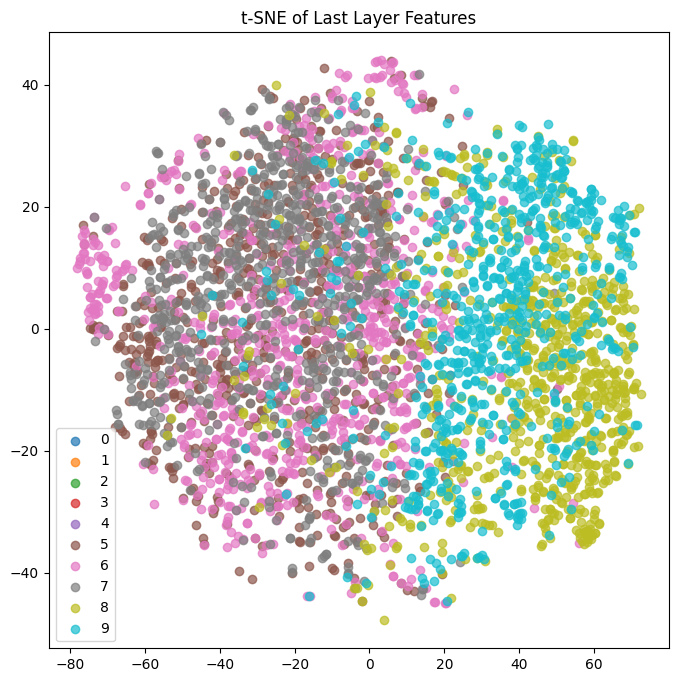

In [82]:
from collections import defaultdict, deque
layers_to_hook = {
    # "early" :    "layer1",   # last Bottleneck of layer1
    # "middle":    "layer2",  # last Bottleneck of layer2
    # "late"  :    "layer3",     # last Bottleneck of layer4
    "last"  :    "vit.layernorm"
}


features = defaultdict(lambda: deque(maxlen=30))  # store max 3 batches per layer

def save_features(name):
    
    def hook(module,args,output):
        features[name].append(output.detach().cpu())
    return hook

def registerhook(model):
    for name,module in model.named_modules():
        if name in layers_to_hook.values():
            module.register_forward_hook(save_features(name))




registerhook(vit_s16_ptrained)

test_vit(vit_s16_ptrained, stylized_loader)

# print(f"Test Acc: {test_accuracy:.2f}")
for name in features:
    for i, batch_features in enumerate(features[name]):
        print(f"Layer: {name}, batch: {i}, shape: {batch_features.shape}")        


concatenated_features = {}

for layer_name, batch_deque in features.items():
    #batch_deque is a deque of tensors 
    concatenated_features[layer_name] = torch.cat(list(batch_deque), dim=0)
    
    print(f"Layer: {layer_name}, concatenated shape: {concatenated_features[layer_name].shape}")

# concatenating together
batch_size = concatenated_features["vit.layernorm"].size(0)

torch.save({
    # "layer1": concatenated_features["layer1"],
    # "layer2": concatenated_features["layer2"],
    # "layer3": concatenated_features["layer3"],
    "vit.layernorm": concatenated_features["vit.layernorm"]
}, "all_features.pt")

# features_flat_1 = concatenated_features["layer1"].view(batch_size, -1).cpu().detach().numpy()
# features_flat_2 = concatenated_features["layer2"].view(batch_size, -1).cpu().detach().numpy()
# features_flat_3 = concatenated_features["layer3"].view(batch_size, -1).cpu().detach().numpy()
features_flat_4 = concatenated_features["vit.layernorm"].view(batch_size, -1).cpu().detach().numpy()

from sklearn.manifold import TSNE
from sklearn.decomposition import PCA
import os
# import torch

os.environ["OMP_NUM_THREADS"] = "1"  # limit OpenMP threads
os.environ["OPENBLAS_NUM_THREADS"] = "1"
torch.set_num_threads(1)

# def get_tsne(features):
    
#     tsne = TSNE(n_components=2, perplexity=30, learning_rate=200, random_state=42)
    
#     embedded_2d = tsne.fit_transform(features)
    
#     print(embedded_2d.shape)
    
#     return embedded_2d


def get_tsne(features, n_pca=50):
    # Step 1: PCA
    pca = PCA(n_components=n_pca, random_state=42)
    features_pca = pca.fit_transform(features)
    # print(f"PCA explained variance: {pca.explained_variance_ratio_.sum():.3f}")
    
    # Step 2: t-SNE on PCA features
    tsne = TSNE(n_components=2, perplexity=30, learning_rate=200, random_state=42)
    embedded_2d = tsne.fit_transform(features_pca)
    
    return embedded_2d

'''
Rule of thumb:

Usually between 5 and 50.
Should be less than the number of samples. 
A common heuristic: perplexity < N / 3 where N is the number of samples.
'''

# embedded_f1 = get_tsne(features_flat_1)
# embedded_f2 = get_tsne(features_flat_2)
# embedded_f3 = get_tsne(features_flat_3)
embedded_f4 = get_tsne(features_flat_4)

import matplotlib.pyplot as plt

# Comment them out once to get the last labels
last_labels = deque(maxlen=30)

for _, labels in stylized_loader:
    last_labels.append(labels)

labels = torch.cat(list(last_labels), dim=0)

print(labels.shape)

labels = labels.cpu().numpy()

def plot_tsne(embedded, labels, title="t-SNE", n_classes=10):
    plt.figure(figsize=(8, 8))
    for i in range(n_classes):
        idxs = labels == i
        plt.scatter(embedded[idxs, 0], embedded[idxs, 1], label=str(i), alpha=0.7)
    plt.legend()
    plt.title(title)
    plt.show()

# plot_tsne(embedded_f1, labels, title="t-SNE of Layer 1 Features")
# plot_tsne(embedded_f2, labels, title="t-SNE of Layer 2 Features")
# plot_tsne(embedded_f3, labels, title="t-SNE of Layer 3 Features")
plot_tsne(embedded_f4, labels, title="t-SNE of Last Layer Features")


# Domain Generalization Test

Link to download PACS:  

https://github.com/lingeringlight/DomainDrop?tab=readme-ov-file

In [83]:
from torch.utils.data import ConcatDataset

transform = transforms.Compose([
    transforms.Resize((224,224)),
    transforms.ToTensor(),
    transforms.Normalize(mean,sd)
])

train_domains = ["photo", "art_painting", "cartoon"]
test_domain = "sketch"

train_set = [datasets.ImageFolder(f"/kaggle/input/pacs-set/kfold/{d}", transform=transform) for d in train_domains]

train_dataset = ConcatDataset(train_set)
test_dataset = datasets.ImageFolder(f"/kaggle/input/pacs-set/kfold/sketch", transform=transform)

train_loader = DataLoader(train_dataset, batch_size=128, shuffle=True)
test_loader = DataLoader(test_dataset, batch_size=128, shuffle=False)


Epoch 0: 100%|██████████| 48/48 [00:50<00:00,  1.05s/it]


→ Saved Model
Train Acc: 76.34, Val Acc: 61.82


Epoch 1: 100%|██████████| 48/48 [00:50<00:00,  1.05s/it]


→ Saved Model
Train Acc: 97.33, Val Acc: 62.89


Epoch 2: 100%|██████████| 48/48 [00:50<00:00,  1.06s/it]


→ Saved Model
Train Acc: 99.69, Val Acc: 64.27


Epoch 3: 100%|██████████| 48/48 [00:50<00:00,  1.05s/it]


→ Saved Model
Train Acc: 99.95, Val Acc: 66.17


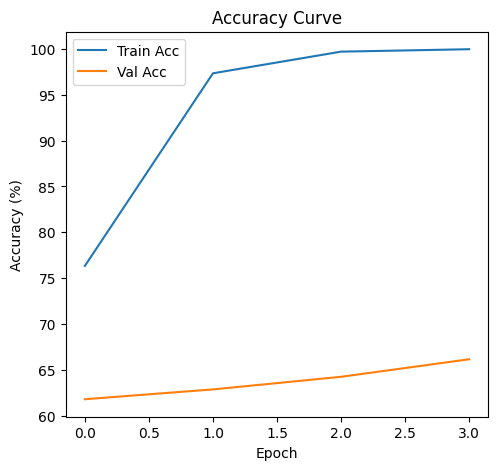

In [70]:
R50_pac_ptrained = models.resnet50(weights="IMAGENET1K_V2")

in_feat = R50_pac_ptrained.fc.in_features
R50_pac_ptrained.fc = nn.Linear(in_features=in_feat, out_features=10)

R50_pac_ptrained = R50_pac_ptrained.to(device)

n_epochs = 4
criteria = nn.CrossEntropyLoss()
optimizer = torch.optim.SGD(R50_pac_ptrained.parameters(),lr=0.01, momentum=0.9,weight_decay=5e-4)

# fine_tune_fc(R50_pac_ptrained)

train_resnet(R50_pac_ptrained, train_loader, test_loader,  n_epochs, optimizer, "fc")


This is a ResNet


Epoch 0: 100%|██████████| 48/48 [00:32<00:00,  1.49it/s]


→ Saved Model
Train Acc: 71.79, Val Acc: 39.35


Epoch 1: 100%|██████████| 48/48 [00:31<00:00,  1.52it/s]


→ Saved Model
Train Acc: 89.24, Val Acc: 41.54


Epoch 2: 100%|██████████| 48/48 [00:31<00:00,  1.53it/s]


→ Saved Model
Train Acc: 91.52, Val Acc: 44.44


Epoch 3: 100%|██████████| 48/48 [00:31<00:00,  1.50it/s]


→ Saved Model
Train Acc: 92.49, Val Acc: 45.28


Epoch 4: 100%|██████████| 48/48 [00:31<00:00,  1.50it/s]


→ Saved Model
Train Acc: 93.32, Val Acc: 47.14


Epoch 5: 100%|██████████| 48/48 [00:32<00:00,  1.48it/s]


→ Saved Model
Train Acc: 93.73, Val Acc: 47.95


Epoch 6: 100%|██████████| 48/48 [00:31<00:00,  1.53it/s]


Train Acc: 94.41, Val Acc: 47.14


Epoch 7: 100%|██████████| 48/48 [00:31<00:00,  1.53it/s]


Train Acc: 94.67, Val Acc: 47.87


Epoch 8: 100%|██████████| 48/48 [00:31<00:00,  1.54it/s]


Train Acc: 95.17, Val Acc: 47.95


Epoch 9: 100%|██████████| 48/48 [00:31<00:00,  1.52it/s]


→ Saved Model
Train Acc: 95.36, Val Acc: 48.13


Epoch 10: 100%|██████████| 48/48 [00:31<00:00,  1.53it/s]


→ Saved Model
Train Acc: 95.25, Val Acc: 48.26


Epoch 11: 100%|██████████| 48/48 [00:31<00:00,  1.53it/s]


Train Acc: 95.58, Val Acc: 47.90


Epoch 12: 100%|██████████| 48/48 [00:31<00:00,  1.54it/s]


→ Saved Model
Train Acc: 95.65, Val Acc: 48.54


Epoch 13: 100%|██████████| 48/48 [00:31<00:00,  1.53it/s]


Train Acc: 95.81, Val Acc: 48.43


Epoch 14: 100%|██████████| 48/48 [00:31<00:00,  1.52it/s]


Train Acc: 96.27, Val Acc: 47.59


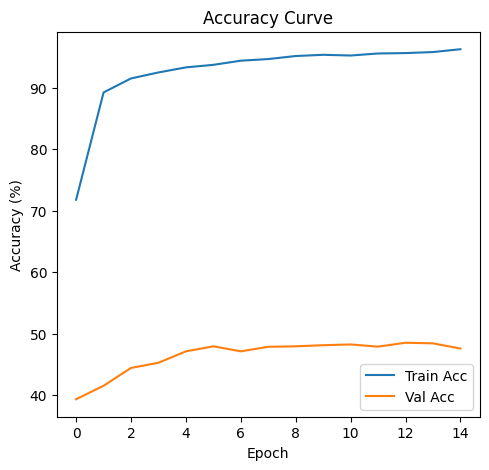

In [84]:
R50_pac_ptrained = models.resnet50(weights="IMAGENET1K_V2")

in_feat = R50_pac_ptrained.fc.in_features
R50_pac_ptrained.fc = nn.Linear(in_features=in_feat, out_features=10)

R50_pac_ptrained = R50_pac_ptrained.to(device)

n_epochs = 15
criteria = nn.CrossEntropyLoss()
optimizer = torch.optim.SGD(R50_pac_ptrained.fc.parameters(),lr=0.01, momentum=0.9,weight_decay=5e-4)

fine_tune_fc(R50_pac_ptrained)

train_resnet(R50_pac_ptrained, train_loader, test_loader,  n_epochs, optimizer, "fc")


Some weights of ViTForImageClassification were not initialized from the model checkpoint at WinKawaks/vit-small-patch16-224 and are newly initialized because the shapes did not match:
- classifier.bias: found shape torch.Size([1000]) in the checkpoint and torch.Size([10]) in the model instantiated
- classifier.weight: found shape torch.Size([1000, 384]) in the checkpoint and torch.Size([10, 384]) in the model instantiated
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


This is a ViT


Epoch 0: 100%|██████████| 48/48 [00:31<00:00,  1.55it/s]


→ Saved Model
Train Acc: 65.28, Val Acc: 30.64


Epoch 1: 100%|██████████| 48/48 [00:31<00:00,  1.54it/s]


→ Saved Model
Train Acc: 89.92, Val Acc: 33.60


Epoch 2: 100%|██████████| 48/48 [00:31<00:00,  1.54it/s]


→ Saved Model
Train Acc: 92.77, Val Acc: 37.95


Epoch 3: 100%|██████████| 48/48 [00:31<00:00,  1.55it/s]


Train Acc: 93.85, Val Acc: 35.38


Epoch 4: 100%|██████████| 48/48 [00:30<00:00,  1.55it/s]


→ Saved Model
Train Acc: 94.64, Val Acc: 40.26


Epoch 5: 100%|██████████| 48/48 [00:30<00:00,  1.56it/s]


→ Saved Model
Train Acc: 95.12, Val Acc: 40.70


Epoch 6: 100%|██████████| 48/48 [00:30<00:00,  1.56it/s]


→ Saved Model
Train Acc: 95.61, Val Acc: 42.58


Epoch 7: 100%|██████████| 48/48 [00:30<00:00,  1.55it/s]


→ Saved Model
Train Acc: 95.99, Val Acc: 44.67


Epoch 8: 100%|██████████| 48/48 [00:31<00:00,  1.55it/s]


→ Saved Model
Train Acc: 96.09, Val Acc: 46.12


Epoch 9: 100%|██████████| 48/48 [00:31<00:00,  1.54it/s]


Train Acc: 96.42, Val Acc: 43.55


Epoch 10: 100%|██████████| 48/48 [00:31<00:00,  1.54it/s]


Train Acc: 96.49, Val Acc: 45.89


Epoch 11: 100%|██████████| 48/48 [00:30<00:00,  1.55it/s]


→ Saved Model
Train Acc: 96.62, Val Acc: 47.80


Epoch 12: 100%|██████████| 48/48 [00:30<00:00,  1.55it/s]


Train Acc: 96.93, Val Acc: 47.70


Epoch 13: 100%|██████████| 48/48 [00:30<00:00,  1.55it/s]


→ Saved Model
Train Acc: 96.95, Val Acc: 48.46


Epoch 14: 100%|██████████| 48/48 [00:31<00:00,  1.55it/s]


Train Acc: 96.96, Val Acc: 46.86


Epoch 15: 100%|██████████| 48/48 [00:31<00:00,  1.54it/s]


Train Acc: 97.16, Val Acc: 47.77


Epoch 16: 100%|██████████| 48/48 [00:32<00:00,  1.48it/s]


→ Saved Model
Train Acc: 97.21, Val Acc: 48.54


Epoch 17: 100%|██████████| 48/48 [00:31<00:00,  1.55it/s]


Train Acc: 97.25, Val Acc: 48.38


Epoch 18: 100%|██████████| 48/48 [00:31<00:00,  1.55it/s]


→ Saved Model
Train Acc: 97.53, Val Acc: 49.17


Epoch 19: 100%|██████████| 48/48 [00:30<00:00,  1.55it/s]


Train Acc: 97.49, Val Acc: 48.49


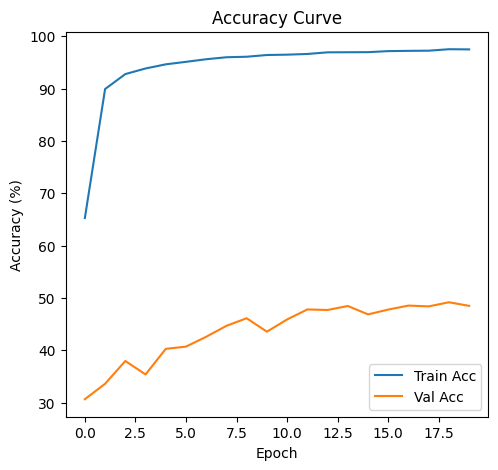

In [62]:

ckpt = "WinKawaks/vit-small-patch16-224"  #pretrained on imagenet - taken from hugging face
vit_s16_ptrained = ViTForImageClassification.from_pretrained(ckpt, num_labels=10, ignore_mismatched_sizes=True)
vit_s16_ptrained = vit_s16_ptrained.to(device)

n_epochs = 20
optimizer = torch.optim.Adam(vit_s16_ptrained.classifier.parameters(),lr=5e-4, weight_decay=0.05)

fine_tune_fc(vit_s16_ptrained)
train_vit(vit_s16_ptrained ,train_loader, test_loader, n_epochs, optimizer, 'classifier')




In [56]:
import torch

# your class names
classes = ['dog', 'elephant', 'giraffe', 'guitar', 'horse', 'house', 'person']

def test_topk_with_true_labels(model, loader, device, classes, k=3):
    model.eval()
    correct_topk = 0
    total = 0
    results = []  # list of tuples: (true_class, [top-k predictions])

    with torch.no_grad():
        for imgs, labels in loader:
            imgs, labels = imgs.to(device), labels.to(device)

            # Get outputs
            outputs = model(imgs)
            if hasattr(outputs, 'logits'):
                outputs = outputs.logits  # for ViT

            # Top-k predictions
            topk_vals, topk_preds = torch.topk(outputs, k=k, dim=1)

            # Convert indices to class names
            topk_names = [[classes[idx] for idx in sample] for sample in topk_preds.cpu().tolist()]
            true_names = [classes[label.item()] for label in labels]

            # Count correct top-k
            correct_topk += sum([true_names[i] in topk_names[i] for i in range(labels.size(0))])
            total += labels.size(0)

            # Store results
            for t, preds in zip(true_names, topk_names):
                results.append((t, preds))

    topk_acc = (correct_topk / total) * 100
    return topk_acc, results


In [59]:
# vit_top3_acc, vit_top3_results = test_topk_with_true_labels(vit_s16_ptrained, test_loader, device, classes)
# resnet_top3_acc, resnet_top3_results = test_topk_with_true_labels(R50_pac_ptrained, test_loader, device, classes)

print(f"ViT Top-3 Accuracy: {vit_top3_acc:.2f}%")
print("ViT Top-3 Predictions (first 5 samples):")
for true_class, top3_preds in vit_top3_results[:10]:
    print(f"True: {true_class}, Top-3: {top3_preds}")

print(f"ResNet Top-3 Accuracy: {resnet_top3_acc:.2f}%")
print("ResNet Top-3 Predictions (first 5 samples):")
for true_class, top3_preds in resnet_top3_results[:10]:
    print(f"True: {true_class}, Top-3: {top3_preds}")


ViT Top-3 Accuracy: 78.82%
ViT Top-3 Predictions (first 5 samples):
True: dog, Top-3: ['person', 'dog', 'guitar']
True: dog, Top-3: ['horse', 'dog', 'elephant']
True: dog, Top-3: ['dog', 'horse', 'person']
True: dog, Top-3: ['person', 'dog', 'elephant']
True: dog, Top-3: ['person', 'dog', 'elephant']
True: dog, Top-3: ['person', 'dog', 'elephant']
True: dog, Top-3: ['dog', 'horse', 'person']
True: dog, Top-3: ['dog', 'person', 'horse']
True: dog, Top-3: ['dog', 'elephant', 'horse']
True: dog, Top-3: ['elephant', 'person', 'dog']
ResNet Top-3 Accuracy: 84.17%
ResNet Top-3 Predictions (first 5 samples):
True: dog, Top-3: ['elephant', 'dog', 'person']
True: dog, Top-3: ['horse', 'elephant', 'dog']
True: dog, Top-3: ['elephant', 'dog', 'horse']
True: dog, Top-3: ['elephant', 'dog', 'person']
True: dog, Top-3: ['elephant', 'dog', 'person']
True: dog, Top-3: ['elephant', 'dog', 'horse']
True: dog, Top-3: ['elephant', 'dog', 'horse']
True: dog, Top-3: ['elephant', 'dog', 'horse']
True: dog, T